<h1><center>SAS Deep Learning Python (DLPy) Time Series Example </center></h1>

This is the notebook for the video: [Time series forecasting using RNNs](http://players.brightcove.net/1872491364001/default_default/index.html?videoId=6001747359001)

## Outline

### 1. Business Problem
### 2. Time Series Preprocessing
### 3. Building Recurrent Neural Network (RNN) Model 
### 4. Result Visualization

## 1. Business Problem

Trying to predict the one-step-ahead max temperature, based on other weather information and previous temperature information.

The data we used here is obtained and modified from https://www.ncdc.noaa.gov/crn/qcdatasets.html. For more information regarding the original data, see Diamond, H. J., T. R. Karl, M. A. Palecki, C. B. Baker, J. E. Bell, R. D. Leeper, D. R. Easterling, J. H. Lawrimore, T. P. Meyers, M. R. Helfert, G. Goodge, and P. W. Thorne, 2013: U.S. Climate Reference Network after one decade of operations: status and assessment. Bull. Amer. Meteor. Soc., 94, 489-498. 

![title](./datasources/durham_temp.png)

* **T_MAX**, which is the maximum temperature.
* **P_CALC**, which is the precipitation.
* **sin_Hr**, which is sin transformed hour variable.
* **cos_Hr**, which is cos transformed hour variable.
* **sin_day_of_year**, which is sin transformed day of the year variable.
* **cos_day_of_year**, which is cos transformed day of the year variable.

## 2. Time Series Preprocessing with DLPY

### Load essential modules

In [1]:
import datetime
from swat import *
from dlpy import Model, Sequential, TimeseriesTable
from dlpy.layers import * 
from dlpy.applications import *
from dlpy.model import Optimizer, AdamSolver, Sequence, DLPyDict
from dlpy.timeseries import plot_timeseries
%matplotlib inline

conn = CAS('hostname', your-port-number)
data_client_path = './datasources/durham_v2.csv'

### Step 1. Loading the table

In [2]:
durham_tbl = TimeseriesTable.from_localfile(conn, data_client_path)

NOTE: Cloud Analytic Services made the uploaded file available as table TS_2HZ4 in caslib CASUSER(user-name).
NOTE: The table TS_2HZ4 has been created in caslib CASUSER(user-name) from binary data uploaded to Cloud Analytic Services.


In [3]:
durham_tbl.head()

,LST_DATE,LST_TIME,T_MAX,P_CALC,year,month,day,hour,datetime,day_of_year,sin_day_of_year,cos_day_of_year,sin_Hr,cos_Hr
0,20071231.0,2000.0,6.8,0.0,2007.0,12.0,31.0,20.0,2007-12-31 20:00:00,365.0,-0.004301,0.999991,-0.866025,0.500000
1,20071231.0,2100.0,7.7,0.0,2007.0,12.0,31.0,21.0,2007-12-31 21:00:00,365.0,-0.004301,0.999991,-0.707107,0.707107
2,20071231.0,2200.0,7.2,0.0,2007.0,12.0,31.0,22.0,2007-12-31 22:00:00,365.0,-0.004301,0.999991,-0.500000,0.866025
3,20071231.0,2300.0,6.9,0.0,2007.0,12.0,31.0,23.0,2007-12-31 23:00:00,365.0,-0.004301,0.999991,-0.258819,0.965926
4,20080101.0,0.0,6.5,0.0,2008.0,1.0,1.0,0.0,2008-01-01 00:00:00,1.0,0.017202,0.999852,0.000000,1.000000


In [4]:
durham_tbl.datetime.dtype

'varchar'

### Step 2. Formatting time series

** 1. Convert timeid to appropriate format** 

** 2. Convert time series to numeric format**

In [5]:
# Specify time series
timeseries_list = ['T_MAX','P_CALC','sin_Hr','cos_Hr', 'sin_day_of_year','cos_day_of_year']

# Formatting time series
durham_tbl.timeseries_formatting(timeid='datetime',timeseries=timeseries_list, extra_columns=[], timeid_informat='anydtdtm19.')

NOTE: Timeseries formatting is completed.


In [6]:
durham_tbl.timeid_type

'datetime'

### Step 3. Accumulate time series

** 1. Accumulate time series to appropriate time frequency** 

** 2. Identify discontinuous timestamps**

In [7]:
# Accumulate time series
durham_tbl.timeseries_accumlation(acc_interval='hour', acc_method_byvar={'T_MAX':'max', 
                                                                         'sin_Hr':'avg',
                                                                         'cos_Hr':'avg',
                                                                        'sin_day_of_year':'avg', 
                                                                        'cos_day_of_year':'avg'})

NOTE: Added action set 'timeData'.
NOTE: Timeseries are accumulated to the frequency of hour


### Step 4. Prepare subsequences

** 1. Convert time series to subsequences with sliding window** 

** 2. This is done through creating lag variables and each subsequence is a row**

In [8]:
# Make time series into subsequences
durham_tbl.prepare_subsequences(seq_len=5, target='T_MAX', predictor_timeseries=timeseries_list)

NOTE: timeseries subsequences are prepared with subsequence length = 5


### Step 5.  Splitting data

** 1. Splitting the data into training, validation and testing by time** 

** 2. Training is prior to validation and validation is prior to testing in terms of time domain**

In [9]:
# Split time series into train and test -- python time!
validation_start = datetime.date(2017,1,1)
testing_start = datetime.date(2017,11,1)

train_tbl, valid_tbl, test_tbl = durham_tbl.timeseries_partition(validation_start=validation_start, testing_start=testing_start)

NOTE: Training set has 78678 observations
NOTE: Validation set has 7223 observations
NOTE: Testing set has 1432 observations


## 3. Building Recurrent Neural Network (RNN) Model with DLPY

### Step 6. Specifying RNN model

** 1. Two Layer RNN model**

NOTE: Input layer added.
NOTE: Recurrent layer added.
NOTE: Recurrent layer added.
NOTE: Output layer added.
NOTE: Model compiled successfully.


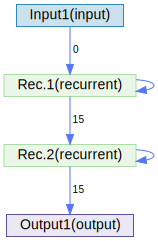

In [10]:
model1 = Sequential(conn, model_table='lstm_rnn')
model1.add(InputLayer(std='STD'))
model1.add(Recurrent(rnn_type='LSTM', output_type='samelength', n=15, reversed_=False))
model1.add(Recurrent(rnn_type='LSTM', output_type='encoding', n=15, reversed_=False))
model1.add(OutputLayer(act='IDENTITY'))
model1.plot_network()

### Step 7. Specifying training options

** 1. Specify optimizer**

** 2. Specify sequence options**

In [11]:
optimizer = Optimizer(algorithm=AdamSolver(learning_rate=0.01), mini_batch_size=32, seed=1234, max_epochs=50)
                           
seq_spec  = Sequence(**train_tbl.sequence_opt)

### Step 8. Training and Visualization

** 1. Create Input list which is organized in an appropriate order (most distant time is at first in the list)** 

** 2. Specify output**

** 3. Specify training and validation tables**

** 4. Visualize the training process**

NOTE: Training from scratch.


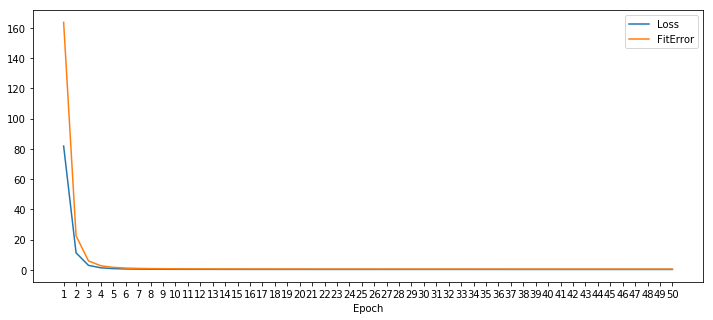

In [12]:
result = model1.fit(train_tbl, valid_table=valid_tbl, optimizer=optimizer, sequence=seq_spec, **train_tbl.inputs_target)
model1.plot_training_history()

### Step 9. Prediction

In [13]:
result = model1.predict(test_tbl)
resulttbl = model1.valid_res_tbl

## 4. Visualize Forecasting plot

### Step 10. Plotting

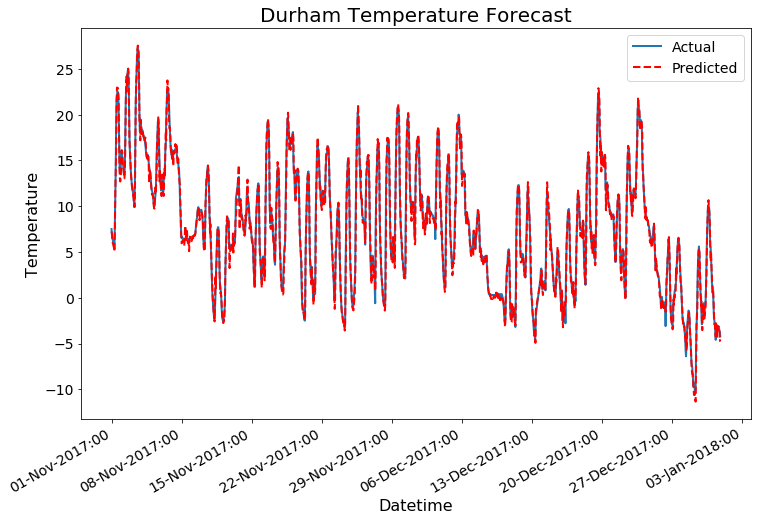

In [14]:
figure1 = plot_timeseries(resulttbl, 'datetime', 'T_MAX', label='Actual', xdate_format='%d-%b-%Y:%H', figsize=(12, 8), 
                        xlabel='Datetime', ylabel='Temperature', linewidth=2, title='Durham Temperature Forecast')

figure2 = plot_timeseries(resulttbl, 'datetime', '_DL_Pred_', label='Predicted', figure = figure1, linestyle='--', color='red',
                        linewidth=2)


### Quick find of doc

In [15]:
help(plot_timeseries)

Help on function plot_timeseries in module dlpy.timeseries:

plot_timeseries(tbl, timeid, timeseries, figure=None, groupid=None, start_time=None, end_time=None, xlim=None, ylim=None, xlabel=None, ylabel=None, xdate_format=None, title=None, figsize=None, fontsize_spec=None, **kwargs)
    Create an timeseries line plot from a CASTable or pandas DataFrame
    
    Parameters
    ----------
    tbl : :class:`CASTable` or :class:`pandas.DataFrame` or :class:`pandas.Series`
        The input table for the plot. If it is CASTable, it will be fetched to 
        the client. If it is pandas.Series, the index name will become timeid, 
        the series name will become timeseries. 
    timeid : str
        The name of the timeid variable. It will be the value to be used in the 
        x-axis.
    timeseries : str
        The name of the column contains the timeseries value. It will be the
        value to be used in the y-axis.
    figure : two-element-tuple, optional
        The tuple must be